<a href="https://colab.research.google.com/github/rahiakela/deep-learning-with-python-francois-chollet/blob/3-getting-started-with-neural-networks/classifying_newswires_multiclass_classification_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying newswires: a multiclass classification example

In this guide, you’ll build a network to classify Reuters newswires into 46 mutually
exclusive topics. Because you have many classes, this problem is an instance of multiclass
classification; and because each data point should be classified into only one category,
the problem is more specifically an instance of single-label, multiclass classification.
If each data point could belong to multiple categories (in this case, topics), you’d be
facing a multilabel, multiclass classification problem.

## Setup

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

TensorFlow 2.x selected.


## The Reuters dataset

You’ll work with the Reuters dataset, a set of short newswires and their topics, published
by Reuters in 1986. It’s a simple, widely used toy dataset for text classification. There
are 46 different topics; some topics are more represented than others, but each topic
has at least 10 examples in the training set.

In [2]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

Using TensorFlow backend.


2113536/2110848 [==============================] - 0s 0us/step


As with the IMDB dataset, the argument num_words=10000 restricts the data to the
10,000 most frequently occurring words found in the data.

You have 8,982 training examples and 2,246 test examples:

In [3]:
len(train_data)

8982

In [4]:
len(test_data)

2246

As with the IMDB reviews, each example is a list of integers (word indices):

In [5]:
print(train_data[10])

[1, 245, 273, 207, 156, 53, 74, 160, 26, 14, 46, 296, 26, 39, 74, 2979, 3554, 14, 46, 4689, 4329, 86, 61, 3499, 4795, 14, 61, 451, 4329, 17, 12]


Here’s how you can decode it back to words, in case you’re curious.

In [6]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])
decoded_newswire

557056/550378 [==============================] - 0s 0us/step


'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

The label associated with an example is an integer between 0 and 45: a topic index.

In [7]:
train_labels[10]

3

## Preparing the data

You can vectorize the data with the exact same code as in the previous example.

In [0]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):
    results[i, sequence] = 1.
  return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)   
# Our vectorized test data
x_test = vectorize_sequences(test_data)

To vectorize the labels, there are two possibilities: you can cast the label list as an integer
tensor, or you can use one-hot encoding. One-hot encoding is a widely used format
for categorical data, also called categorical encoding.

In [0]:
def to_one_hot(labels, dimension=46):
  results = np.zeros((len(labels), dimension))
  for i, label in enumerate(labels):
    results[i, label] = 1.

# Our vectorized training labels
one_hot_train_labels = to_one_hot(train_labels)
# Our vectorized test labels
one_hot_test_labels = to_one_hot(test_labels)

Note that there is a built-in way to do this in Keras, which you have already seen in action in our MNIST example:

In [0]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

## Building your network

This topic-classification problem looks similar to the previous movie-review classification
problem: in both cases, you’re trying to classify short snippets of text. But there is
a new constraint here: the number of output classes has gone from 2 to 46. The
dimensionality of the output space is much larger.

In a stack of Dense layers like that you’ve been using, each layer can only access information
present in the output of the previous layer. 

If one layer drops some information relevant to the classification problem, this information can never be recovered by later
layers: each layer can potentially become an information bottleneck.

In the previous
example, you used 16-dimensional intermediate layers, but a 16-dimensional space may
be too limited to learn to separate 46 different classes: such small layers may act as information
bottlenecks, permanently dropping relevant information.

For this reason you’ll use larger layers. Let’s go with 64 units.

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense 

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(10000, )))
model.add(Dense(64, activation='relu'))
model.add(Dense(46, activation='softmax'))

There are two other things you should note about this architecture:

* We are ending the network with a Dense layer of size 46. This means that for each input sample, our network will output a 46-dimensional vector. Each entry in this vector (each dimension) will encode a different output class.
* The last layer uses a softmax activation. You have already seen this pattern in the MNIST example. It means that the network will output a probability distribution over the 46 different output classes, i.e. for every input sample, the network will produce a 46-dimensional output vector where output[i] is the probability that the sample belongs to class i. The 46 scores will sum to 1.

The best loss function to use in this case is categorical_crossentropy. It measures
the distance between two probability distributions: here, between the probability distribution
output by the network and the true distribution of the labels. By minimizing
the distance between these two distributions, you train the network to output something
as close as possible to the true labels.

In [0]:
# Compiling the model
model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

## Validating our approach

Let’s set apart 1,000 samples in the training data to use as a validation set.

In [0]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

Now let's train our network for 20 epochs:

In [14]:
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 284us/sample - loss: 2.6986 - accuracy: 0.4888 - val_loss: 1.7581 - val_accuracy: 0.6220
Epoch 2/20
7982/7982 [==============================] - 1s 131us/sample - loss: 1.4392 - accuracy: 0.7077 - val_loss: 1.2837 - val_accuracy: 0.7190
Epoch 3/20
7982/7982 [==============================] - 1s 130us/sample - loss: 1.0439 - accuracy: 0.7785 - val_loss: 1.1148 - val_accuracy: 0.7610
Epoch 4/20
7982/7982 [==============================] - 1s 132us/sample - loss: 0.8078 - accuracy: 0.8343 - val_loss: 0.9974 - val_accuracy: 0.7880
Epoch 5/20
7982/7982 [==============================] - 1s 125us/sample - loss: 0.6453 - accuracy: 0.8662 - val_loss: 0.9355 - val_accuracy: 0.8020
Epoch 6/20
7982/7982 [==============================] - 1s 129us/sample - loss: 0.5116 - accuracy: 0.8924 - val_loss: 0.9017 - val_accuracy: 0.8090
Epoch 7/20
7982/7982 [==============================] - 1s 130us

And finally, let’s display its loss and accuracy curves

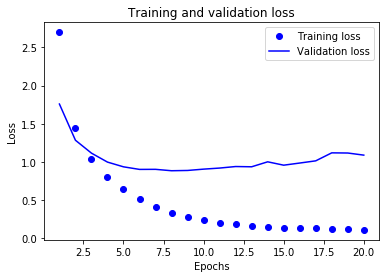

In [16]:
# Plotting the training and validation loss

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

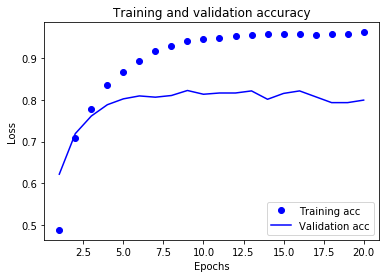

In [18]:
# Plotting the training and validation accuracy
plt.clf()  # Clears the figure

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

It seems that the network starts overfitting after 8 epochs. Let's train a new network from scratch for 8 epochs, then let's evaluate it on the test set:

In [21]:
# Retraining a model from scratch
model_1 = Sequential()
model_1.add(Dense(64, activation='relu', input_shape=(10000,)))
model_1.add(Dense(64, activation='relu'))
model_1.add(Dense(46, activation='softmax'))

# compile the model
model_1.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
model_1.fit(partial_x_train, partial_y_train, epochs=9, batch_size=512, validation_data=(x_val, y_val))

# evaluate the model
results = model_1.evaluate(x_test, one_hot_test_labels, verbose=0)

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 2s 197us/sample - loss: 2.5913 - accuracy: 0.5144 - val_loss: 1.7553 - val_accuracy: 0.6570
Epoch 2/9
7982/7982 [==============================] - 1s 132us/sample - loss: 1.4200 - accuracy: 0.7093 - val_loss: 1.3143 - val_accuracy: 0.7220
Epoch 3/9
7982/7982 [==============================] - 1s 129us/sample - loss: 1.0481 - accuracy: 0.7770 - val_loss: 1.1177 - val_accuracy: 0.7530
Epoch 4/9
7982/7982 [==============================] - 1s 133us/sample - loss: 0.8160 - accuracy: 0.8286 - val_loss: 1.0176 - val_accuracy: 0.7890
Epoch 5/9
7982/7982 [==============================] - 1s 131us/sample - loss: 0.6483 - accuracy: 0.8648 - val_loss: 0.9736 - val_accuracy: 0.7990
Epoch 6/9
7982/7982 [==============================] - 1s 133us/sample - loss: 0.5150 - accuracy: 0.8925 - val_loss: 0.9216 - val_accuracy: 0.8100
Epoch 7/9
7982/7982 [==============================] - 1s 134us/sample

In [22]:
# Here are the final results:
results

[0.9913695648325838, 0.7885129]

Our approach reaches an accuracy of ~79%. With a balanced binary classification problem, the accuracy reached by a purely random classifier would be 50%, but in our case it is closer to 19%, so our results seem pretty good, at least when compared to a random baseline:

In [23]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

0.18833481745325023

## Generating predictions on new data

You can verify that the predict method of the model instance returns a probability
distribution over all 46 topics. 

Let’s generate topic predictions for all of the test data.

In [0]:
predictions = model_1.predict(x_test)

Each entry in predictions is a vector of length 46:

In [25]:
predictions

array([[1.1156764e-05, 9.5084615e-05, 1.5400976e-05, ..., 1.1598611e-05,
        4.3780274e-06, 1.6140214e-06],
       [1.3424801e-04, 2.2391187e-02, 1.6259550e-03, ..., 6.8566718e-05,
        6.3503899e-07, 3.7239829e-06],
       [6.7562973e-03, 5.5681020e-01, 6.7945924e-03, ..., 8.5651409e-04,
        4.6754585e-04, 1.5339967e-02],
       ...,
       [7.6752658e-05, 5.4826273e-04, 9.4287534e-05, ..., 6.9928632e-05,
        4.9822218e-05, 9.8325972e-06],
       [6.6498556e-04, 1.8002285e-02, 9.9272253e-03, ..., 6.9013203e-04,
        4.5092046e-04, 3.9416080e-04],
       [9.1718584e-03, 4.9222201e-01, 2.4617186e-02, ..., 7.1959675e-04,
        1.5530243e-04, 2.9840968e-03]], dtype=float32)

In [26]:
predictions[0].shape

(46,)

The coefficients in this vector sum to 1:

In [27]:
np.sum(predictions[0])

1.0000001

The largest entry is the predicted class—the class with the highest probability:

In [28]:
np.argmax(predictions[0])

3

The lowest entry is the predicted class—the class with the lowest probability:

In [29]:
np.argmin(predictions[0])

22

## A different way to handle the labels and the loss

Another way to encode the labels would be to cast them as
an integer tensor, like this:

In [0]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

The only thing it would change is the choice of the loss function. Our previous loss, **categorical_crossentropy**, expects the labels to follow a categorical encoding. With integer labels, we should use **sparse_categorical_crossentropy**:

In [0]:
model_1.compile(optimizer='RMSprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

This new loss function is still mathematically the same as categorical_crossentropy;
it just has a different interface.

## The importance of having sufficiently large intermediate layers

Because the final outputs are 46-dimensional, you should
avoid intermediate layers with many fewer than 46 hidden units. 

Now let’s see what happens when you introduce an information bottleneck by having intermediate layers that are significantly less than 46-dimensional: for example, 4-dimensional.

In [34]:
model_2 = Sequential()
model_2.add(Dense(64, activation='relu', input_shape=(10000, )))
model_2.add(Dense(4, activation='relu'))
model_2.add(Dense(46, activation='softmax'))

# compile the model
model_2.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
history_2 = model_2.fit(partial_x_train, partial_y_train, epochs=20, batch_size=128, validation_data=(x_val, y_val))

# evaluate the model
results_2 = model_2.evaluate(x_test, one_hot_test_labels, verbose=0)

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 286us/sample - loss: 2.9635 - accuracy: 0.2803 - val_loss: 2.1880 - val_accuracy: 0.6040
Epoch 2/20
7982/7982 [==============================] - 2s 188us/sample - loss: 1.7422 - accuracy: 0.6185 - val_loss: 1.5530 - val_accuracy: 0.6150
Epoch 3/20
7982/7982 [==============================] - 1s 184us/sample - loss: 1.3815 - accuracy: 0.6352 - val_loss: 1.4319 - val_accuracy: 0.6200
Epoch 4/20
7982/7982 [==============================] - 1s 187us/sample - loss: 1.2394 - accuracy: 0.6710 - val_loss: 1.4125 - val_accuracy: 0.6540
Epoch 5/20
7982/7982 [==============================] - 1s 186us/sample - loss: 1.1448 - accuracy: 0.7028 - val_loss: 1.3659 - val_accuracy: 0.6620
Epoch 6/20
7982/7982 [==============================] - 1s 185us/sample - loss: 1.0698 - accuracy: 0.7146 - val_loss: 1.3911 - val_accuracy: 0.6660
Epoch 7/20
7982/7982 [==============================] - 2s 191us

In [37]:
results_2

[2.3715223660982834, 0.6500445]

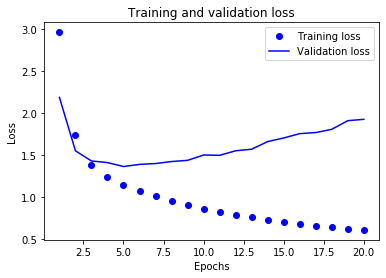

In [35]:
# Plotting the training and validation loss
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

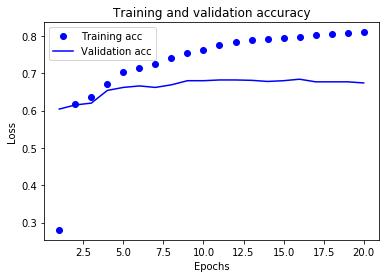

In [36]:
# Plotting the training and validation accuracy
plt.clf()  # Clears the figure

acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

The network now peaks at ~71% validation accuracy, an 8% absolute drop. This drop
is mostly due to the fact that you’re trying to compress a lot of information (enough
information to recover the separation hyperplanes of 46 classes) into an intermediate
space that is too low-dimensional. The network is able to cram most of the necessary
information into these eight-dimensional representations, but not all of it.

## Further experiments

* Step-1: Try using larger or smaller layers: 32 units, 128 units, and so on.
* Step-2: You used two hidden layers. Now try using a single hidden layer, or three hidden layers.

### Step-1: Try using larger or smaller layers: 32 units

In [38]:
model_3 = Sequential()
model_3.add(Dense(32, activation='relu', input_shape=(10000, )))
model_3.add(Dense(32, activation='relu'))
model_3.add(Dense(46, activation='softmax'))

# compile the model
model_3.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
history_3 = model_3.fit(partial_x_train, partial_y_train, epochs=20, batch_size=128, validation_data=(x_val, y_val))

# evaluate the model
results_3 = model_3.evaluate(x_test, one_hot_test_labels, verbose=0)

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 211us/sample - loss: 2.2507 - accuracy: 0.5417 - val_loss: 1.4784 - val_accuracy: 0.6600
Epoch 2/20
7982/7982 [==============================] - 1s 129us/sample - loss: 1.2174 - accuracy: 0.7321 - val_loss: 1.1621 - val_accuracy: 0.7590
Epoch 3/20
7982/7982 [==============================] - 1s 126us/sample - loss: 0.9036 - accuracy: 0.8051 - val_loss: 1.0289 - val_accuracy: 0.7770
Epoch 4/20
7982/7982 [==============================] - 1s 130us/sample - loss: 0.6960 - accuracy: 0.8449 - val_loss: 0.9599 - val_accuracy: 0.8070
Epoch 5/20
7982/7982 [==============================] - 1s 127us/sample - loss: 0.5398 - accuracy: 0.8805 - val_loss: 0.9056 - val_accuracy: 0.8100
Epoch 6/20
7982/7982 [==============================] - 1s 126us/sample - loss: 0.4221 - accuracy: 0.9107 - val_loss: 0.9222 - val_accuracy: 0.8060
Epoch 7/20
7982/7982 [==============================] - 1s 127us

In [39]:
results_3

[1.445103563374955, 0.77025825]

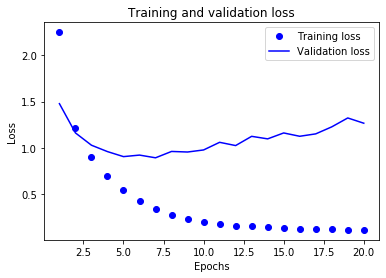

In [40]:
# Plotting the training and validation loss
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

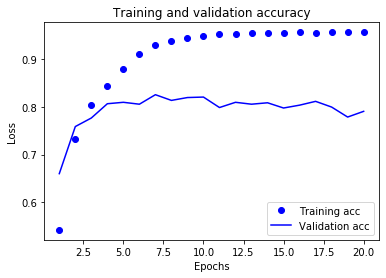

In [41]:
# Plotting the training and validation accuracy
plt.clf()  # Clears the figure

acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Step-1: Try using larger or smaller layers: 128 units

In [42]:
model_4 = Sequential()
model_4.add(Dense(128, activation='relu', input_shape=(10000, )))
model_4.add(Dense(128, activation='relu'))
model_4.add(Dense(46, activation='softmax'))

# compile the model
model_4.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
history_4 = model_4.fit(partial_x_train, partial_y_train, epochs=20, batch_size=128, validation_data=(x_val, y_val))

# evaluate the model
results_4 = model_4.evaluate(x_test, one_hot_test_labels, verbose=0)

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 3s 327us/sample - loss: 1.5603 - accuracy: 0.6678 - val_loss: 1.0779 - val_accuracy: 0.7610
Epoch 2/20
7982/7982 [==============================] - 2s 244us/sample - loss: 0.7699 - accuracy: 0.8267 - val_loss: 0.9164 - val_accuracy: 0.8180
Epoch 3/20
7982/7982 [==============================] - 2s 245us/sample - loss: 0.4564 - accuracy: 0.9017 - val_loss: 0.9114 - val_accuracy: 0.7970
Epoch 4/20
7982/7982 [==============================] - 2s 244us/sample - loss: 0.2983 - accuracy: 0.9337 - val_loss: 0.9142 - val_accuracy: 0.8070
Epoch 5/20
7982/7982 [==============================] - 2s 242us/sample - loss: 0.2268 - accuracy: 0.9450 - val_loss: 0.9226 - val_accuracy: 0.8210
Epoch 6/20
7982/7982 [==============================] - 2s 242us/sample - loss: 0.1917 - accuracy: 0.9501 - val_loss: 0.9528 - val_accuracy: 0.8110
Epoch 7/20
7982/7982 [==============================] - 2s 243us

In [43]:
results_4

[2.1550351934356553, 0.77515584]

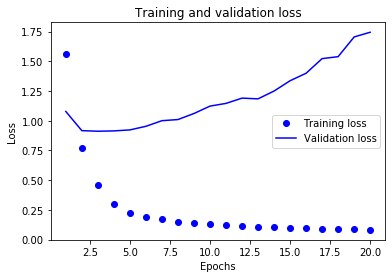

In [44]:
# Plotting the training and validation loss
loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

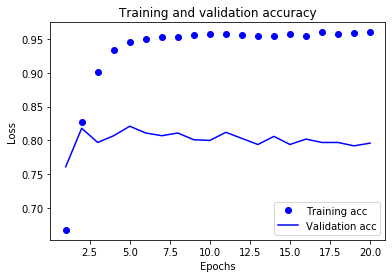

In [45]:
# Plotting the training and validation accuracy
plt.clf()  # Clears the figure

acc = history_4.history['accuracy']
val_acc = history_4.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Step-2: Try using a single hidden layer.

In [46]:
model_5 = Sequential()
model_5.add(Dense(64, activation='relu', input_shape=(10000, )))
model_5.add(Dense(46, activation='softmax'))

# compile the model
model_5.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
history_5 = model_5.fit(partial_x_train, partial_y_train, epochs=20, batch_size=128, validation_data=(x_val, y_val))

# evaluate the model
results_5 = model_5.evaluate(x_test, one_hot_test_labels, verbose=0)

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 218us/sample - loss: 1.9499 - accuracy: 0.6319 - val_loss: 1.2561 - val_accuracy: 0.7270
Epoch 2/20
7982/7982 [==============================] - 1s 157us/sample - loss: 0.9598 - accuracy: 0.8028 - val_loss: 1.0003 - val_accuracy: 0.7980
Epoch 3/20
7982/7982 [==============================] - 1s 161us/sample - loss: 0.6548 - accuracy: 0.8649 - val_loss: 0.8891 - val_accuracy: 0.8300
Epoch 4/20
7982/7982 [==============================] - 1s 160us/sample - loss: 0.4694 - accuracy: 0.9027 - val_loss: 0.8334 - val_accuracy: 0.8240
Epoch 5/20
7982/7982 [==============================] - 1s 158us/sample - loss: 0.3482 - accuracy: 0.9283 - val_loss: 0.8186 - val_accuracy: 0.8280
Epoch 6/20
7982/7982 [==============================] - 1s 165us/sample - loss: 0.2702 - accuracy: 0.9380 - val_loss: 0.8200 - val_accuracy: 0.8320
Epoch 7/20
7982/7982 [==============================] - 1s 162us

In [47]:
results_5

[1.3989958015808757, 0.7760463]

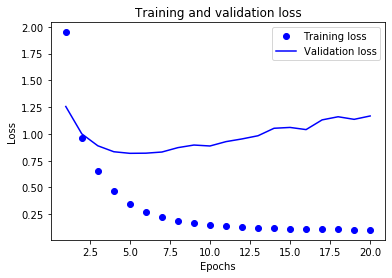

In [48]:
# Plotting the training and validation loss
loss = history_5.history['loss']
val_loss = history_5.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

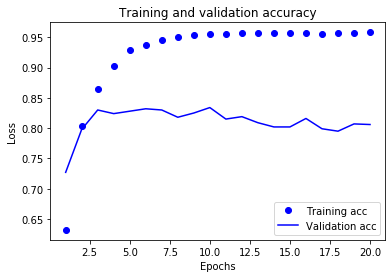

In [49]:
# Plotting the training and validation accuracy
plt.clf()  # Clears the figure

acc = history_5.history['accuracy']
val_acc = history_5.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Step-2: Try using three hidden layers.

In [50]:
model_6 = Sequential()
model_6.add(Dense(64, activation='relu', input_shape=(10000, )))
model_6.add(Dense(64, activation='relu'))
model_6.add(Dense(64, activation='relu'))
model_6.add(Dense(46, activation='softmax'))

# compile the model
model_6.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
history_6 = model_6.fit(partial_x_train, partial_y_train, epochs=20, batch_size=128, validation_data=(x_val, y_val))

# evaluate the model
results_6 = model_6.evaluate(x_test, one_hot_test_labels, verbose=0)

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 304us/sample - loss: 1.8739 - accuracy: 0.6004 - val_loss: 1.2749 - val_accuracy: 0.7060
Epoch 2/20
7982/7982 [==============================] - 1s 186us/sample - loss: 1.0139 - accuracy: 0.7695 - val_loss: 1.0793 - val_accuracy: 0.7690
Epoch 3/20
7982/7982 [==============================] - 2s 192us/sample - loss: 0.6886 - accuracy: 0.8482 - val_loss: 0.9748 - val_accuracy: 0.7850
Epoch 4/20
7982/7982 [==============================] - 1s 179us/sample - loss: 0.4787 - accuracy: 0.8955 - val_loss: 0.9816 - val_accuracy: 0.7930
Epoch 5/20
7982/7982 [==============================] - 1s 162us/sample - loss: 0.3438 - accuracy: 0.9265 - val_loss: 0.9850 - val_accuracy: 0.8140
Epoch 6/20
7982/7982 [==============================] - 1s 162us/sample - loss: 0.2694 - accuracy: 0.9401 - val_loss: 1.0418 - val_accuracy: 0.7970
Epoch 7/20
7982/7982 [==============================] - 1s 160us

In [52]:
results_6

[1.7494782497069714, 0.769813]

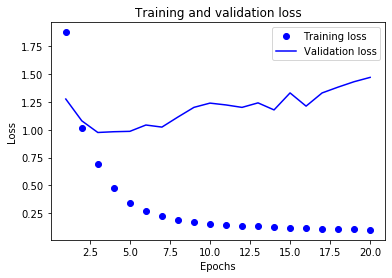

In [53]:
# Plotting the training and validation loss
loss = history_6.history['loss']
val_loss = history_6.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

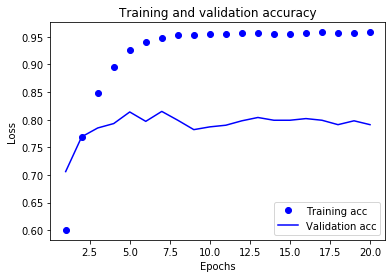

In [54]:
# Plotting the training and validation accuracy
plt.clf()  # Clears the figure

acc = history_6.history['accuracy']
val_acc = history_6.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Wrapping up

Here’s what you should take away from this example:
* If you’re trying to classify data points among N classes, your network should end with a Dense layer of size N.
* In a single-label, multiclass classification problem, your network should end
with a softmax activation so that it will output a probability distribution over the N output classes.
* Categorical crossentropy is almost always the loss function you should use for
such problems. It minimizes the distance between the probability distributions
output by the network and the true distribution of the targets.
* There are two ways to handle labels in multiclass classification:
  * Encoding the labels via categorical encoding (also known as one-hot encoding) and using categorical_crossentropy as a loss function
  * Encoding the labels as integers and using the sparse_categorical_crossentropy loss function
* If you need to classify data into a large number of categories, you should avoid creating information bottlenecks in your network due to intermediate layers that are too small.